In [2]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
import importlib
importlib.reload(dataset) 
MAXLEN = 60
BATCH_SIZE = 64  # 512
data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN,
                         filenames=['texts/short_table.txt', 'texts/treasure_island.txt', 'texts/ahava.txt', 'texts/ali_baba.txt', 'texts/bible.txt'])  # 'texts/bible.txt',


In [17]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 2**10  # larger -> quicker opening. knee at 1024

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

h = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)
# h = layers.Dropout(DROP)(h)

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)  # =l2(1e-6)
h = layers.Dropout(0.5)(h) 

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)
h = layers.Dropout(0.5)(h) 

# h = h1  # layers.Add()([h1, h])
    
h = layers.Dense(256, activation='relu', kernel_regularizer=l2(5e-5))(h)
h = layers.Dropout(0.5)(h) 
#h = layers.Add()([h1, h])
# for k in range(1):
#     h = layers.Add()([h, Dense(256)(h)])

h = layers.Dense(data.niqqud_texts.shape[2])(h)
model_niqqud = tf.keras.Model(inputs=[inp], outputs=[h])
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_niqqud.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['accuracy'])

plot_model(model_niqqud, to_file='model.png')
model_niqqud.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 60)]                0         
_________________________________________________________________
embedding_3 (Embedding)      (64, 60, 1024)            74752     
_________________________________________________________________
bidirectional_6 (Bidirection (64, 60, 256)             1969152   
_________________________________________________________________
dropout_9 (Dropout)          (64, 60, 256)             0         
_________________________________________________________________
bidirectional_7 (Bidirection (64, 60, 256)             789504    
_________________________________________________________________
dropout_10 (Dropout)         (64, 60, 256)             0         
_________________________________________________________________
dense_6 (Dense)              (64, 60, 256)             6579

In [18]:

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model_niqqud.fit(data.input_texts, data.niqqud_texts,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, data.niqqud_validation),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, verbose=1),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=0.0001),
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=15)

Train on 41472 samples, validate on 4608 samples
Epoch 1/15
41472/41472 [==============================] - 51s 1ms/sample - loss: 0.0112 - accuracy: 0.7570 - val_loss: 0.0069 - val_accuracy: 0.8429
Epoch 2/15
41472/41472 [==============================] - 40s 955us/sample - loss: 0.0067 - accuracy: 0.8563 - val_loss: 0.0051 - val_accuracy: 0.8878
Epoch 3/15
41472/41472 [==============================] - 40s 955us/sample - loss: 0.0053 - accuracy: 0.8883 - val_loss: 0.0043 - val_accuracy: 0.9087
Epoch 4/15
41472/41472 [==============================] - 40s 960us/sample - loss: 0.0046 - accuracy: 0.9048 - val_loss: 0.0039 - val_accuracy: 0.9191
Epoch 5/15
41472/41472 [==============================] - 40s 959us/sample - loss: 0.0042 - accuracy: 0.9141 - val_loss: 0.0036 - val_accuracy: 0.9254
Epoch 6/15
41472/41472 [==============================] - 40s 961us/sample - loss: 0.0039 - accuracy: 0.9203 - val_loss: 0.0035 - val_accuracy: 0.9300
Epoch 7/15
41472/41472 [=======================

In [ ]:
history1 = fit(EPOCHS=5)

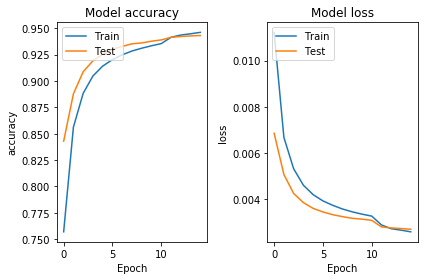

In [19]:
import matplotlib.pyplot as plt

for n, v in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, n)
    plt.plot(history.history[v][0:])
    plt.plot(history.history['val_' +  v][0:])
    plt.title('Model ' + v)
    plt.ylabel(v)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
plt.tight_layout()

In [20]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(h)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    actual = model.predict(batch)
    expected = data.niqqud_validation[s]
    for a, e in zip(data.merge(batch, ns=actual), data.merge(batch, ns=expected)):
        print(a)
        print(e)
        print()

print_predictions(2)

וְהָעָם אֲשֶר-עִמוֹ לִפְנֵי אֲרָם לַמִלְחָמָה וַיָנוּסוּ מִפָנָיו וּבְנֵי עַמוֹן רְאוּ
וְהָעָם אֲשֶר-עִמוֹ לִפְנֵי אֲרָם לַמִלְחָמָה וַיָנוּסוּ מִפָנָיו וּבְנֵי עַמוֹן רָאוּ

וְלֹא-יַהֲרֹס עוֹד לְעוֹלָם הַדָבָר אֲשֶר-הָיָה אֶל-יִרְמְיָהוּ מֵאֵת יְהוָה בַשָנָה
וְלֹא-יֵהָרֵס עוֹד לְעוֹלָם הַדָבָר אֲשֶר-הָיָה אֶל-יִרְמְיָהוּ מֵאֵת יְהוָה בַשָנָה

רֹאש בֵין עֵינֶיךָ קִבְלוּ רַבוֹתֵינוּ זִכְרוֹנָם לִבְרָכָה שֶאֵין זֹאת בֵין עֵינֶיךָ
רֹאש בֵין עֵינֶיךָ קִבְלוּ רַבוֹתֵינוּ זִכְרוֹנָם לִבְרָכָה שֶאֵין זֹאת בֵין עֵינֶיךָ

מָעוֹן תָנִים יָדַעְתִי יְהוָה כִי לֹא לְאָדָם דַרְכוֹ לֹא-לְאִיש הָלֵךְ וְהֵכִין
מְעוֹן תַנִים יָדַעְתִי יְהוָה כִי לֹא לָאָדָם דַרְכוֹ לֹא-לְאִיש הֹלֵךְ וְהָכִין

הַכָרוּךְ שְלִיש וְהֶעָנָף שְנֵי שְלִישִין. וְיֵש מִי שֶאֵינוֹ מְדַקְדֵק דָבָר זֶה
הַכָרוּךְ שְלִיש וְהֶעָנָף שְנֵי שְלִישִין. וְיֵש מִי שֶאֵינוֹ מְדַקְדֵק דָבָר זֶה

אוֹתָה עִם לִפָתָן הָיוּ שִבְעִים הֲוֵי לֵיה גַם כֵן דִין לֶחֶם אִם מִתְחִלָה הָיָה
אוֹתָה עִם לִפְתָן הָיוּ שְבֵעִים הֲוֵי לֵיה גַם כֵן דִין לֶחֶם א

In [ ]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit